<a href="https://colab.research.google.com/github/hochthom/OG-AI4Artists-2023/blob/main/Image-Generation/ai4artists_stable_diffusion_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion Inpainting** 🎨 
*...using `🧨diffusers`*

This Colab notebook shows how to use Stable Diffusion for inpainting with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

Let's get started!

## 1. How to use `StableDiffusionPipeline`



### Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [ ]:
!nvidia-smi

Wed Apr 19 08:26:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.1 MB/s eta 0:00:00


### Stable Diffusion Pipeline for Inpainting

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline

MODEL = "stabilityai/stable-diffusion-2-inpainting"        # 512x512

pipe = StableDiffusionInpaintPipeline.from_pretrained( MODEL, torch_dtype=torch.float16)


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Next, let's move the pipeline to GPU to have faster inference.

In [ ]:
pipe = pipe.to("cuda")

And we are ready for inpainting

## 2. Prepare Image for Inpainting

Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load image and mask

In [ ]:
from PIL import Image

DATA_DIR = './'
#DATA_DIR = '/content/drive/'

image = Image.open(DATA_DIR + '823709736320_sd-gen_image.png')
img_with_mask = Image.open(DATA_DIR + '823709736320_sd-gen_image_mask.png')

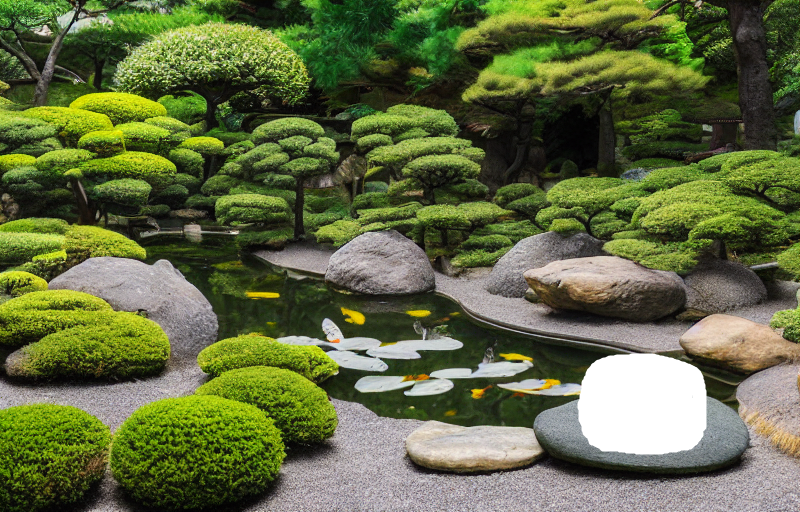

In [ ]:
img_with_mask

In [ ]:
import numpy as np

mask = np.array(img_with_mask)

px_val = 255   # for white, use 0 for black
mask = (mask[:,:,0] == px_val) & (mask[:,:,1] == px_val) & (mask[:,:,2] == px_val)
mask = mask.astype(np.uint8) * 255
mask = Image.fromarray(np.dstack([mask, mask, mask]))

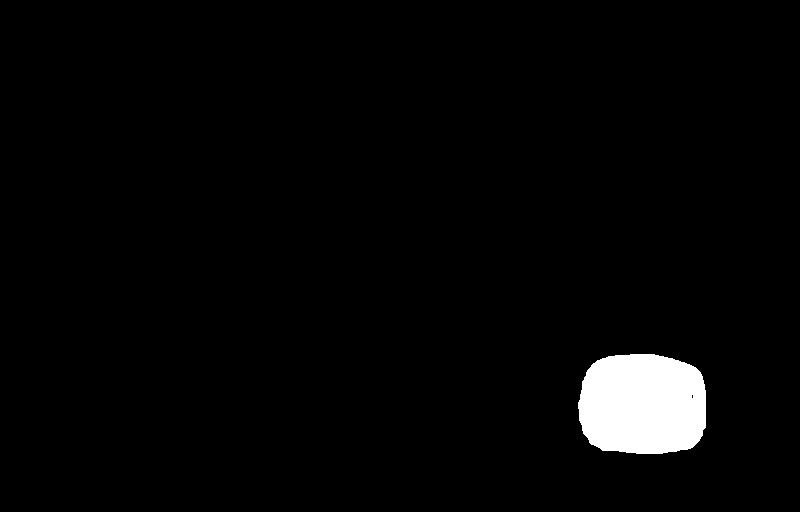

In [ ]:
mask

### Crop and Resizing to 512x512

What is the size of our images?

In [ ]:
image.size

(800, 512)

Let's first define which part of the image to change

In [ ]:
x1, x2 = 1000-512, 800
y1, y2 = 200, 512
if (x2-x1) != (y2-y1):
  print('Image part definition is not square!')

Crop and resize them to 512x512

In [ ]:
image_pp = image.crop((x1, y1, x2, y2)).resize((512, 512))
mask_pp = mask.crop((x1, y1, x2, y2)).resize((512, 512))

In [ ]:
print('Image/Mask size:', image_pp.size, mask_pp.size)

Image/Mask size: (512, 512) (512, 512)


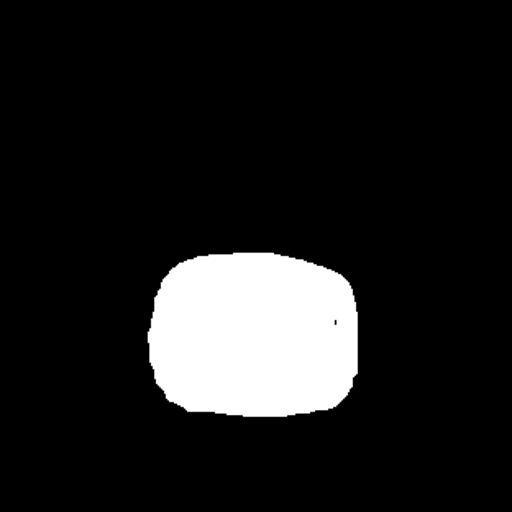

In [ ]:
mask_pp

## 3. Creating Image

  0%|          | 0/50 [00:00<?, ?it/s]

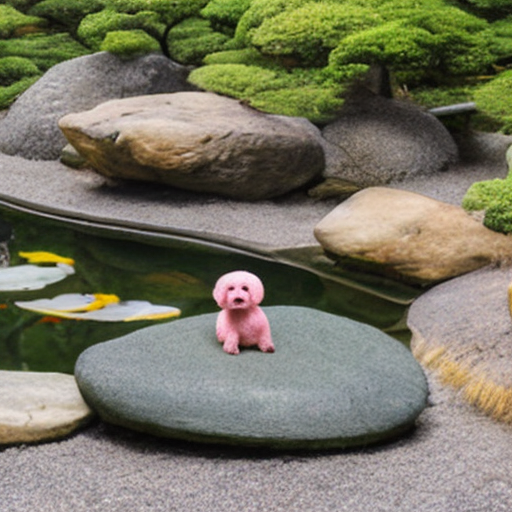

In [ ]:
prompt = "A japanese zen garden with a pink dog sitting on a stone, high resolution."

#image and mask should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_gen = pipe(prompt=prompt, image=image_pp, mask_image=mask_pp, guidance_scale=8).images[0]

# if you're in a google colab you can directly display it with 
image_gen

## 4. Paste generated image back to the original

In [ ]:
if (x2-x1) != 512:
  image_gen = image_gen.resize((x2-x1, y2-y1))
image.paste(image_gen, (x1, y1))

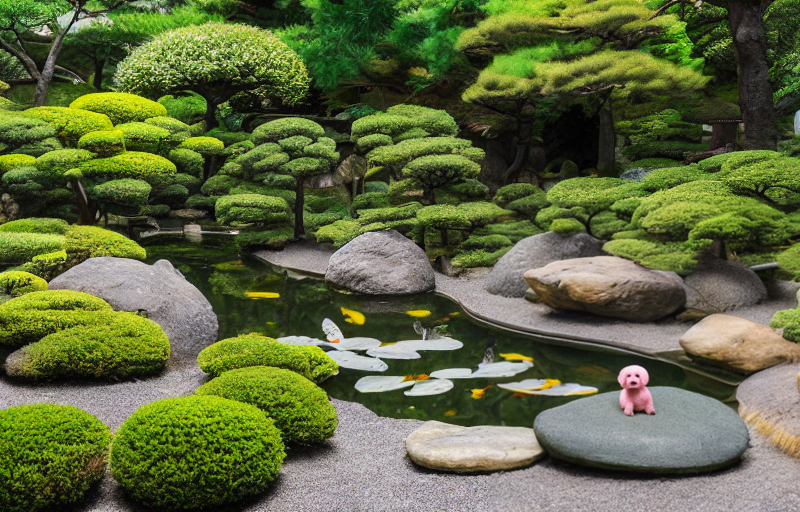

In [ ]:
image